**This notebook is an exercise in the [Computer Vision](https://www.kaggle.com/learn/computer-vision) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/maximum-pooling).**

---


# Introduction #

In these exercises, you'll conclude the feature extraction begun in Exercise 2, explore how invariance is created by maximum pooling, and then look at a different kind of pooling: *average* pooling.

Run the cell below to set everything up.

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.computer_vision.ex3 import *

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import gridspec
import learntools.computer_vision.visiontools as visiontools

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

Run this cell to get back to where you left off in the previous lesson. We'll use a predefined kernel this time.

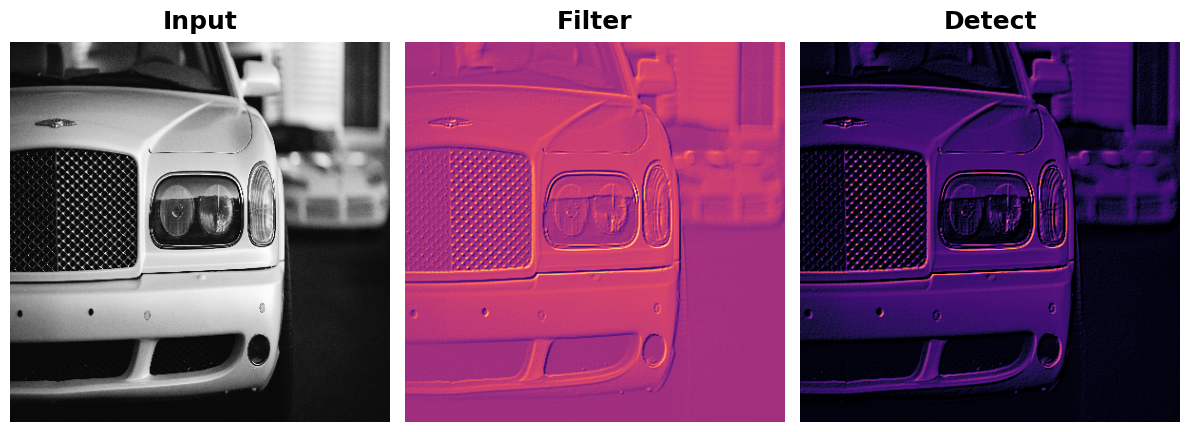

In [2]:
# Read image
image_path = '../input/computer-vision-resources/car_illus.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image, channels=1)
image = tf.image.resize(image, size=[400, 400])

# Embossing kernel
kernel = tf.constant([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2],
])

# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='VALID',
)

image_detect = tf.nn.relu(image_filter)

# Show what we have so far
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.title('Input')
plt.subplot(132)
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Filter')
plt.subplot(133)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('Detect')
plt.show();

# 1) Apply Pooling to Condense #

For for the last step in the sequence, apply maximum pooling using a $2 \times 2$ pooling window. You can copy this code to get started:

```
image_condense = tf.nn.pool(
    input=image_detect,
    window_shape=____,
    pooling_type=____,
    strides=(2, 2),
    padding='SAME',
)
```

In [3]:
# YOUR CODE HERE
image_condense = tf.nn.pool(
    input=image_filter, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # we'll see what these do in the next lesson!
    strides=(2, 2),
    padding='SAME',
)

# Check your answer
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
# Lines below will give you a hint or solution code
#q_1.hint()
#q_1.solution()

Run the next cell to see what maximum pooling did to the feature!

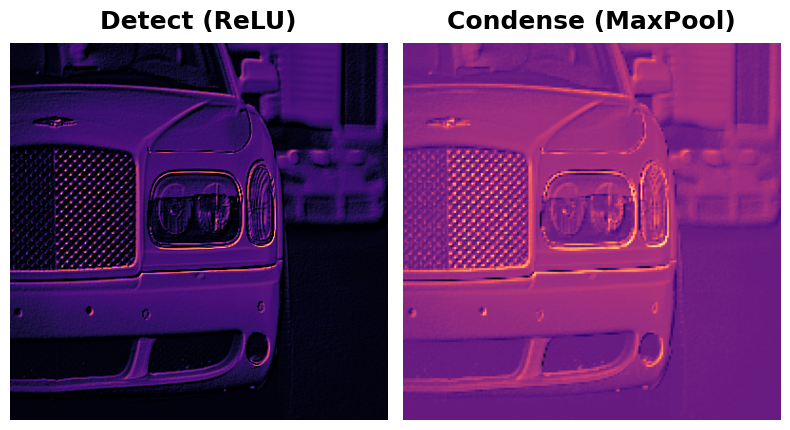

In [4]:
plt.figure(figsize=(8, 6))
plt.subplot(121)
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title("Detect (ReLU)")
plt.subplot(122)
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.title("Condense (MaxPool)")
plt.show();

We learned about how `MaxPool2D` layers give a convolutional network the property of **translation invariance** over small distances. In this exercise, you'll have a chance to observe this in action.

This next code cell will randomly apply a small shift to a circle and then condense the image several times with maximum pooling. Run the cell once and make note of the image that results at the end.

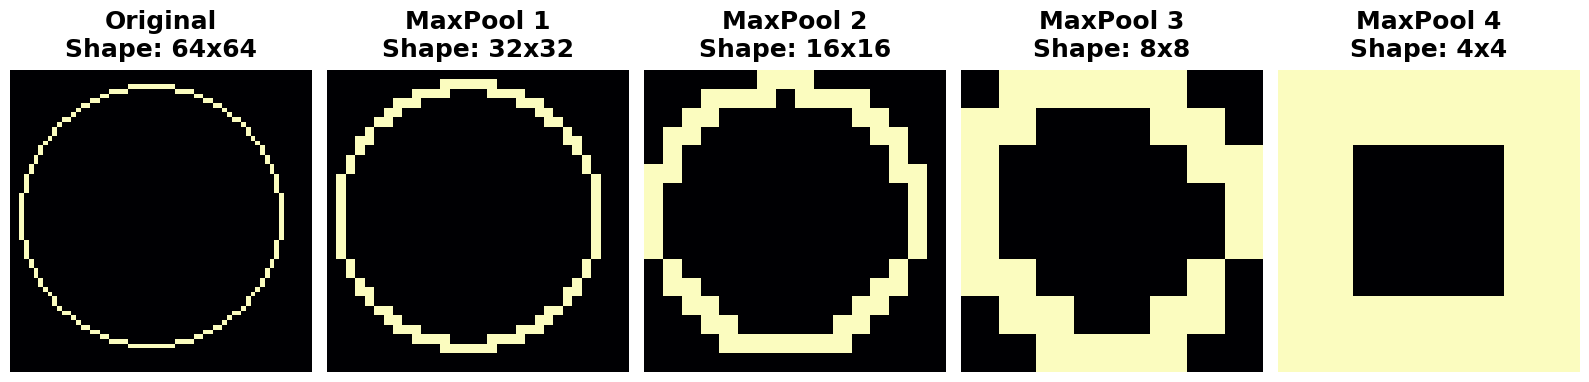

In [8]:
REPEATS = 4
SIZE = [64, 64]

# Create a randomly shifted circle
image = visiontools.circle(SIZE, r_shrink=4, val=1)
image = tf.expand_dims(image, axis=-1)
image = visiontools.random_transform(image, jitter=3, fill_method='replicate')
image = tf.squeeze(image)

plt.figure(figsize=(16, 4))
plt.subplot(1, REPEATS+1, 1)
plt.imshow(image, vmin=0, vmax=1)
plt.title("Original\nShape: {}x{}".format(image.shape[0], image.shape[1]))
plt.axis('off')

# Now condense with maximum pooling several times
for i in range(REPEATS):
    ax = plt.subplot(1, REPEATS+1, i+2)
    image = tf.reshape(image, [1, *image.shape, 1])
    image = tf.nn.pool(image, window_shape=(2,2), strides=(2, 2), padding='SAME', pooling_type='MAX')
    image = tf.squeeze(image)
    plt.imshow(image, vmin=0, vmax=1)
    plt.title("MaxPool {}\nShape: {}x{}".format(i+1, image.shape[0], image.shape[1]))
    plt.axis('off')

# 2) Explore Invariance #


Suppose you had made a small shift in a different direction -- what effect would you expect that have on the resulting image? Try running the cell a few more times, if you like, to get a new random shift.

In [ ]:
# View the solution (Run this code cell to receive credit!)
q_2.solution()

# Global Average Pooling #

We mentioned in the previous exercise that average pooling has largely been superceeded by maximum pooling within the convolutional base. There is, however, a kind of average pooling that is still widely used in the *head* of a convnet. This is **global average pooling**. A `GlobalAvgPool2D` layer is often used as an alternative to some or all of the hidden `Dense` layers in the head of the network, like so:

```
model = keras.Sequential([
    pretrained_base,
    layers.GlobalAvgPool2D(),
    layers.Dense(1, activation='sigmoid'),
])
```

What is this layer doing? Notice that we no longer have the `Flatten` layer that usually comes after the base to transform the 2D feature data to 1D data needed by the classifier. Now the `GlobalAvgPool2D` layer is serving this function. But, instead of "unstacking" the feature (like `Flatten`), it simply replaces the entire feature map with its average value. Though very destructive, it often works quite well and has the advantage of reducing the number of parameters in the model.

Let's look at what `GlobalAvgPool2D` does on some randomly generated feature maps. This will help us to understand how it can "flatten" the stack of feature maps produced by the base.

Run this next cell a few times until you get a feel for how this new layer works.

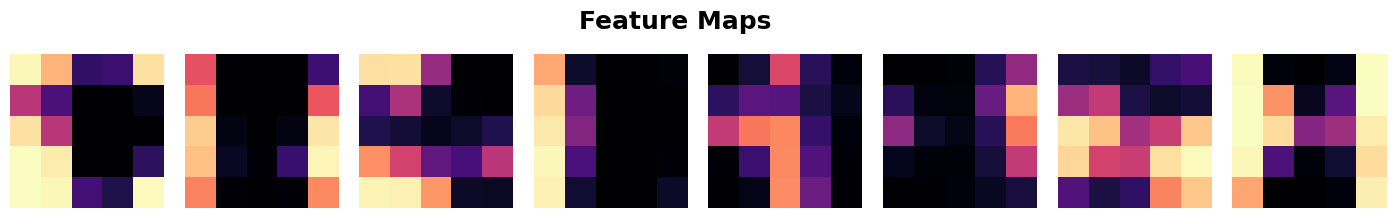

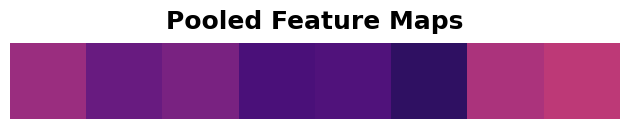

In [10]:
feature_maps = [visiontools.random_map([5, 5], scale=0.1, decay_power=4) for _ in range(8)]

gs = gridspec.GridSpec(1, 8, wspace=0.01, hspace=0.01)
plt.figure(figsize=(18, 2))
for i, feature_map in enumerate(feature_maps):
    plt.subplot(gs[i])
    plt.imshow(feature_map, vmin=0, vmax=1)
    plt.axis('off')
plt.suptitle('Feature Maps', size=18, weight='bold', y=1.1)
plt.show()

# reformat for TensorFlow
feature_maps_tf = [tf.reshape(feature_map, [1, *feature_map.shape, 1])
                   for feature_map in feature_maps]

global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
pooled_maps = [global_avg_pool(feature_map) for feature_map in feature_maps_tf]
img = np.array(pooled_maps)[:,:,0].T

plt.imshow(img, vmin=0, vmax=1)
plt.axis('off')
plt.title('Pooled Feature Maps')
plt.show();

Since each of the $5 \times 5$ feature maps was reduced to a single value, global pooling reduced the number of parameters needed to represent these features by a factor of 25 -- a substantial savings!

Now we'll move on to understanding the pooled features.

After we've pooled the features into just a single value, does the head still have enough information to determine a class? This part of the exercise will investigate that question.

Let's pass some images from our *Car or Truck* dataset through VGG16 and examine the features that result after pooling. First run this cell to define the model and load the dataset.

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Load VGG16
pretrained_base = tf.keras.models.load_model(
    '../input/cv-course-models/cv-course-models/vgg16-pretrained-base',
)

model = keras.Sequential([
    pretrained_base,
    # Attach a global average pooling layer after the base
    layers.GlobalAvgPool2D(),
])

# Load dataset
ds = image_dataset_from_directory(
    '../input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=1,
    shuffle=True,
)

ds_iter = iter(ds)

Found 5117 files belonging to 2 classes.


Notice how we've attached a `GlobalAvgPool2D` layer after the pretrained VGG16 base. Ordinarily, VGG16 will produce 512 feature maps for each image. The `GlobalAvgPool2D` layer reduces each of these to a single value, an "average pixel", if you like.

This next cell will run an image from the *Car or Truck* dataset through VGG16 and show you the 512 average pixels created by `GlobalAvgPool2D`. Run the cell a few times and observe the pixels produced by cars versus the pixels produced by trucks.

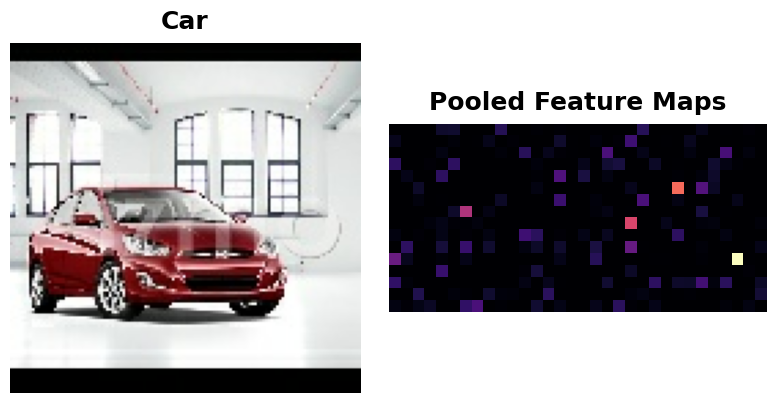

In [23]:
car = next(ds_iter)

car_tf = tf.image.resize(car[0], size=[128, 128])
car_features = model(car_tf)
car_features = tf.reshape(car_features, shape=(16, 32))
label = int(tf.squeeze(car[1]).numpy())

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(tf.squeeze(car[0]))
plt.axis('off')
plt.title(["Car", "Truck"][label])
plt.subplot(122)
plt.imshow(car_features)
plt.title('Pooled Feature Maps')
plt.axis('off')
plt.show();

# 3) Understand the Pooled Features #

What do you see? Are the pooled features for cars and trucks different enough to tell them apart? How would you interpret these pooled values? How could this help the classification? After you've thought about it, run the next cell for an answer. (Or see a hint first!)

In [19]:
# View the solution (Run this code cell to receive credit!)
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

The VGG16 base produces 512 feature maps. We can think of each feature map as representing some high-level visual feature in the original image -- maybe a wheel or window. Pooling a map gives us a single number, which we could think of as a *score* for that feature: large if the feature is present, small if it is absent. Cars tend to score high with one set of features, and Trucks score high with another. Now, instead of trying to map raw features to classes, the head only has to work with these scores that `GlobalAvgPool2D` produced, a much easier problem for it to solve.


In [ ]:
# Line below will give you a hint
#q_3.hint()

Global average pooling is often used in modern convnets. One big advantage is that it greatly reduces the number of parameters in a model, while still telling you if some feature was present in an image or not -- which for classification is usually all that matters. If you're creating a convolutional classifier it's worth trying out!

# Conclusion #

In this lesson we explored the final operation in the feature extraction process: **condensing** with **maximum pooling**. Pooling is one of the essential features of convolutional networks and helps provide them with some of their characteristic advantages: efficiency with visual data, reduced parameter size compared to dense networks, translation invariance. We've seen that it's used not only in the base during feature extraction, but also can be used in the head during classification. Understanding it is essential to a full understanding of convnets.

# Keep Going #

In the next lesson, we'll conclude our discussion of the feature extraction operations with **sliding windows**, the typical way of describing how the convolution and pooling operations scan over an image. We'll describe here the final two parameters in the `Conv2D` and `MaxPool2D` layers: `strides` and `padding`. [**Check it out**](https://www.kaggle.com/ryanholbrook/the-sliding-window) now!

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/computer-vision/discussion) to chat with other learners.*